In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset
from cryoS2Sdrop.model import Denoising_3DUNet, Denoising_3DUNet_v2
from cryoS2Sdrop.losses import self2self_L2Loss
from cryoS2Sdrop.trainer import denoisingTrainer
from cryoS2Sdrop.predict import load_model, predict_full_tomogram

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import pathlib
import json

from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio
from torchsummary import summary
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

PARENT_PATH = setup.PARENT_PATH

def parse_null_arg(arg, dtype):
    try:
        return dtype(arg)
    except ValueError:
        return None

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [7]:
# Here a new patch is used for each prediction
def aux_forward(model, dataset, idx):
    with torch.no_grad():
        subtomo, target, mask, gt = dataset[idx]
        return model(subtomo)

# here the subtomogram is only sampled once
def aux_forward0(model, subtomo):
    with torch.no_grad():
        return model(subtomo)
    
def scale(X):
    scaled = (X - X.min()) / (X.max() - X.min() + 1e-8)
    return scaled

def load_model_and_dataset(tensorboard_logdir, version):
    logdir = os.path.join(tensorboard_logdir, version)

    with open(os.path.join(logdir, "experiment_args.json"), "r") as f:
        exp_args = json.load(f)

    deconv_kwargs = exp_args["deconv_kwargs"]
    predict_simRecon = exp_args["predict_simRecon"]
    use_deconv_as_target = exp_args["use_deconv_as_target"]
    weightedBernoulliMask_prob = parse_null_arg(
        exp_args["weightedBernoulliMask_prob"], float
    )

    print("Loading model from: %s" % logdir)

    model, hparams = load_model(logdir, DataParallel=True)

    dataset = hparams["dataset"]

    cet_path = hparams["tomo_path"]
    gt_cet_path = hparams["gt_tomo_path"]
    p = float(hparams["p"])  # dropout (zeroing) probability
    subtomo_length = int(hparams["subtomo_length"])
    n_features = int(hparams["n_features"])
    volumetric_scale_factor = parse_null_arg(hparams["vol_scale_factor"], float)
    Vmask_probability = parse_null_arg(hparams["Vmask_probability"], float)
    Vmask_pct = parse_null_arg(hparams["Vmask_pct"], float)
    alpha = hparams["loss_fn"]["alpha"]

    if dataset == "singleCET_dataset":
        my_dataset = singleCET_dataset(
            cet_path,
            subtomo_length=subtomo_length,
            p=p,
            n_bernoulli_samples=n_bernoulli_samples,
            volumetric_scale_factor=volumetric_scale_factor,
            Vmask_probability=Vmask_probability,
            Vmask_pct=Vmask_pct,
            transform=None,
            n_shift=0,
            gt_tomo_path=gt_cet_path,
            **deconv_kwargs
        )

    elif dataset == "singleCET_FourierDataset":
        my_dataset = singleCET_FourierDataset(
            cet_path,
            subtomo_length=subtomo_length,
            p=p,
            n_bernoulli_samples=n_bernoulli_samples,
            volumetric_scale_factor=volumetric_scale_factor,
            Vmask_probability=Vmask_probability,
            Vmask_pct=Vmask_pct,
            transform=None,
            n_shift=0,
            gt_tomo_path=gt_cet_path,
            weightedBernoulliMask_prob=weightedBernoulliMask_prob,
            **deconv_kwargs
        )

    elif dataset == "singleCET_ProjectedDataset":
        my_dataset = singleCET_ProjectedDataset(
            cet_path,
            subtomo_length=subtomo_length,
            transform=None,
            n_shift=0,
            gt_tomo_path=gt_cet_path,
            predict_simRecon=predict_simRecon,
            use_deconv_as_target=use_deconv_as_target,
            **deconv_kwargs
        )
        
    return model, my_dataset

def compare_one_subtomo_model_versions(version_list, tensorboard_logdir, resample_patch_each_iter):
    denoised_dict = {}

    for version in version_list:

        model, my_dataset = load_model_and_dataset(tensorboard_logdir, version)

        zidx = my_dataset.subtomo_length//2

        idx = len(my_dataset)//2
        subtomo, target, mask, gt = my_dataset[idx]
        gt = gt.mean((0, 1)).detach().numpy()
        aux_subtomo = (target + subtomo)
        print(aux_subtomo.shape)
        original_subtomo = aux_subtomo.squeeze(1).detach().numpy()[0]
        n0 = 12//len(aux_subtomo)
        n1 = 300//len(aux_subtomo)
        
        if resample_patch_each_iter:
            denoised_subtomo0 = torch.stack([aux_forward(model, my_dataset, idx=idx) for i in range(n0)]).flatten(0, 2).cpu().detach().numpy().mean(0)
            denoised_subtomo1 = torch.stack([aux_forward(model, my_dataset, idx=idx) for i in range(n1)]).flatten(0, 2).cpu().detach().numpy().mean(0)
        else:
            denoised_subtomo0 = torch.stack([aux_forward0(model, subtomo) for i in range(n0)]).flatten(0, 2).cpu().detach().numpy().mean(0)
            denoised_subtomo1 = torch.stack([aux_forward0(model, subtomo) for i in range(n1)]).flatten(0, 2).cpu().detach().numpy().mean(0)
            
        ref = torch.tensor(original_subtomo).unsqueeze(0).unsqueeze(0)
        ref = scale(ref)
        X0 = torch.tensor(denoised_subtomo0).unsqueeze(0).unsqueeze(0)
        X0 = scale(X0)
        X1 = torch.tensor(denoised_subtomo1).unsqueeze(0).unsqueeze(0)
        X1 = scale(X1)
        Y = torch.tensor(gt).unsqueeze(0).unsqueeze(0)
        Y = scale(Y)

        ssim_ref = float(ssim(ref, Y, data_range=1))
        ssim0 = float(ssim(X0, Y, data_range=1))
        ssim1 = float(ssim(X1, Y, data_range=1))

        psnr_ref = float(peak_signal_noise_ratio(ref, Y, data_range=1))
        psnr0 = float(peak_signal_noise_ratio(X0, Y, data_range=1))
        psnr1 = float(peak_signal_noise_ratio(X1, Y, data_range=1))
        
        ref, X0, X1, Y = ref.squeeze(), X0.squeeze(), X1.squeeze(), Y.squeeze()


        fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(22, 10))
        ax0.imshow(X0[zidx], vmin=0, vmax=1)
        ax0.set_title('Prediction with %i samples \n SSIM / PSNR: %.3f / %.3f' %(n0, ssim0, psnr0))
        ax1.imshow(X1[zidx], vmin=0, vmax=1)
        ax1.set_title('Prediction with %i samples \n SSIM / PSNR: %.3f / %.3f' %(n1, ssim1, psnr1))
        ax2.imshow(ref[zidx], vmin=0, vmax=1)
        ax2.set_title('Input \n SSIM / PSNR: %.3f / %.3f' %(ssim_ref, psnr_ref))
        ax3.imshow(Y[zidx], vmin=0, vmax=1)
        ax3.set_title('Ground Truth')
        plt.show()
        denoised_dict[version] = [denoised_subtomo0, denoised_subtomo1]
    
    return denoised_dict

# Predict one subtomo

In [3]:
###################### Parse arguments ###################

exp_name = "realBernoulli_dropoutLevel_comparison"

n_bernoulli_samples = 12

tomo_name = "tomoPhantom_model8_noisyGaussPoissM"

##################################### Model and dataloader ####################################################

tensorboard_logdir = os.path.join(
    PARENT_PATH, "data/S2SDenoising/model_logs/%s/%s/" % (tomo_name, exp_name)
)
pathlib.Path(tensorboard_logdir).mkdir(parents=True, exist_ok=True)

In [4]:
max_version = 3
version_list = ['version_%i'%i for i in range(max_version+1)]

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_0
torch.Size([12, 1, 96, 96, 96])


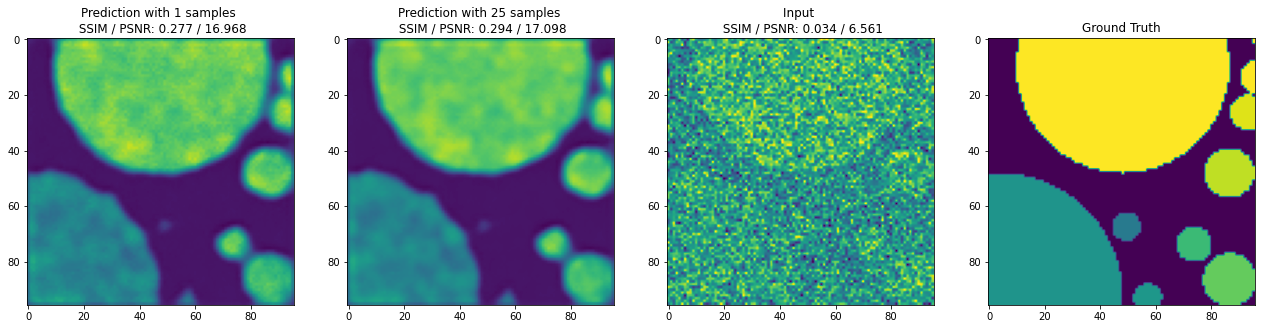

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_1
torch.Size([12, 1, 96, 96, 96])


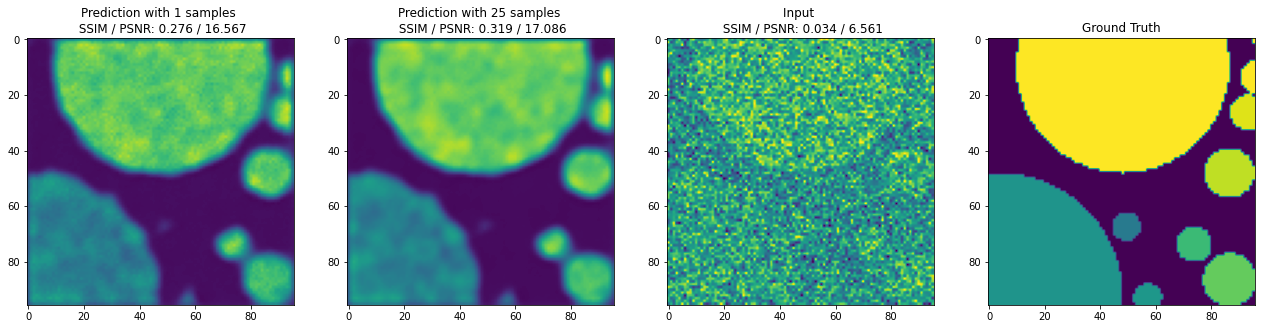

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_2
torch.Size([12, 1, 96, 96, 96])


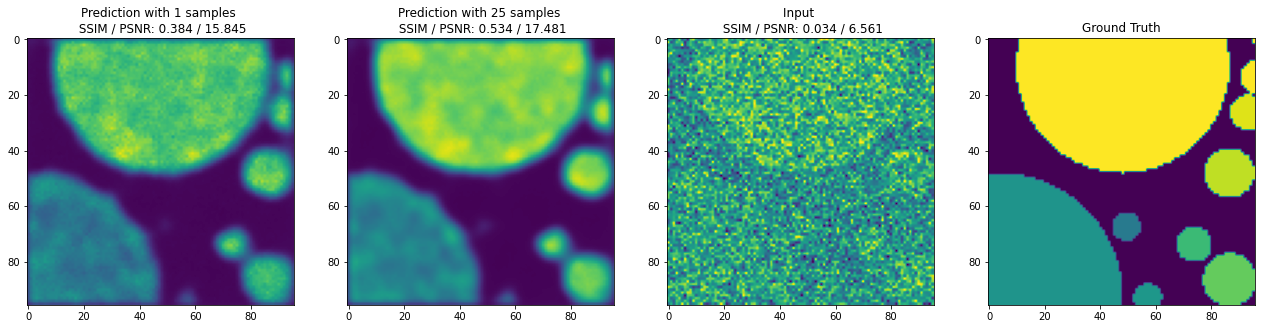

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_3
torch.Size([12, 1, 96, 96, 96])


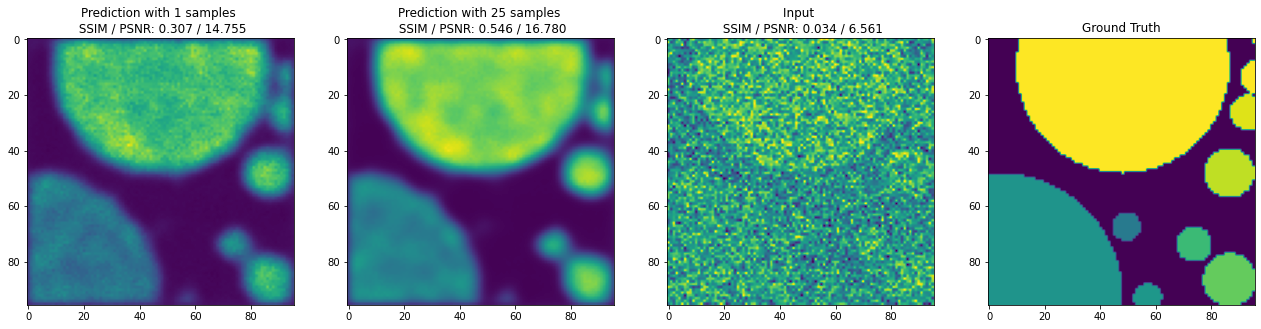

In [5]:
denoised_dict = compare_one_subtomo_model_versions(version_list, tensorboard_logdir, resample_patch_each_iter=True)

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_0
torch.Size([12, 1, 96, 96, 96])


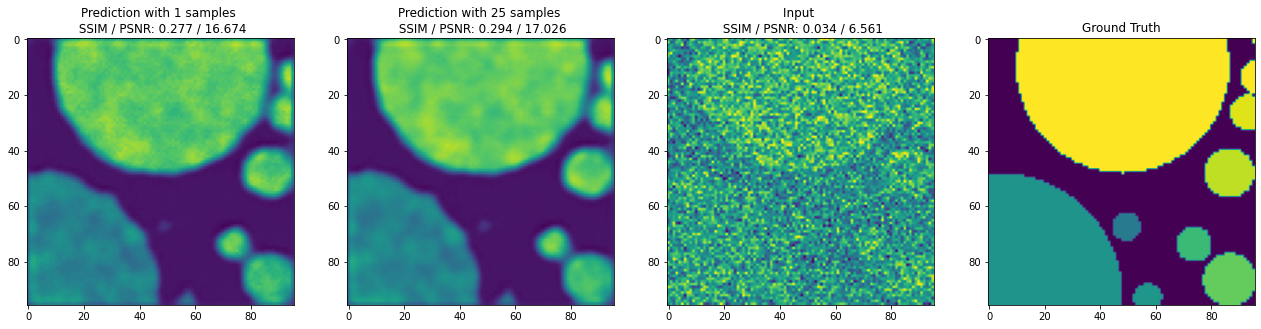

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_1
torch.Size([12, 1, 96, 96, 96])


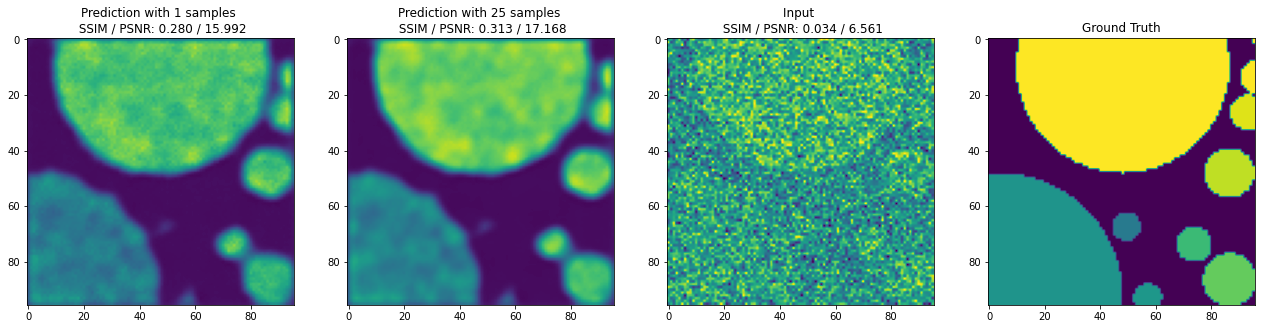

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_2
torch.Size([12, 1, 96, 96, 96])


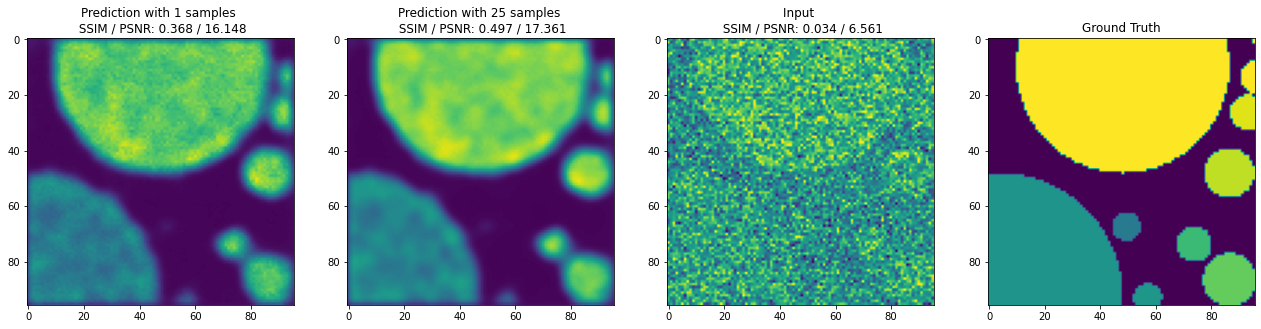

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_3
torch.Size([12, 1, 96, 96, 96])


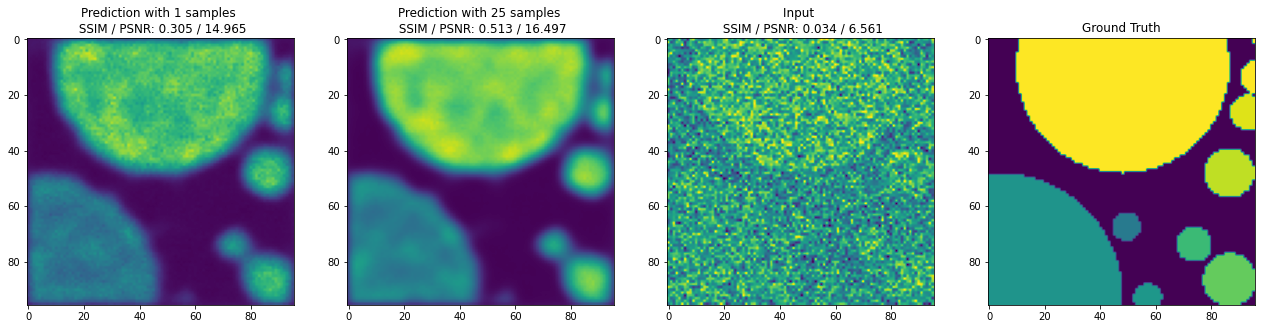

In [8]:
denoised_dict = compare_one_subtomo_model_versions(version_list, tensorboard_logdir, resample_patch_each_iter=False)